# 强化学习 Atari 游戏 Demo

本笔记本演示如何使用 Dueling DQN 算法训练智能体玩 Atari 游戏 Assault-v5。

## 目录
1. [环境设置](#环境设置)
2. [数据预处理](#数据预处理)
3. [模型架构](#模型架构)
4. [训练过程](#训练过程)
5. [结果可视化](#结果可视化)
6. [模型评估](#模型评估)

In [17]:
# 导入必要的库
import sys
import os
sys.path.append('../src')

import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import HTML, display
from tqdm.notebook import tqdm

# 导入自定义模块
from model import DQN, DuelingDQN
from agent import DQNAgent
from utils import make_env, plot_rewards, record_video

# 设置matplotlib中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


device = "mps" if torch.backends.mps.is_built() \
    else "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print("环境设置完成！")

mps
环境设置完成！


## 环境设置

首先创建游戏环境并查看其基本信息。

In [18]:
# 创建环境
env_name = 'ALE/Assault-v5'
env = make_env(env_name)

print(f"环境名称: {env_name}")
print(f"观测空间: {env.observation_space}")
print(f"动作空间: {env.action_space}")
print(f"动作数量: {env.action_space.n}")

# 重置环境并显示初始状态
state, _ = env.reset()
print(f"状态形状: {state.shape}")
print(f"状态数据类型: {state.dtype}")
print(f"状态值范围: [{state.min()}, {state.max()}]")

环境名称: ALE/Assault-v5
观测空间: Box(0, 255, (4, 84, 84), uint8)
动作空间: Discrete(7)
动作数量: 7
状态形状: (4, 84, 84)
状态数据类型: uint8
状态值范围: [0, 168]


## 数据预处理

查看预处理后的游戏画面。

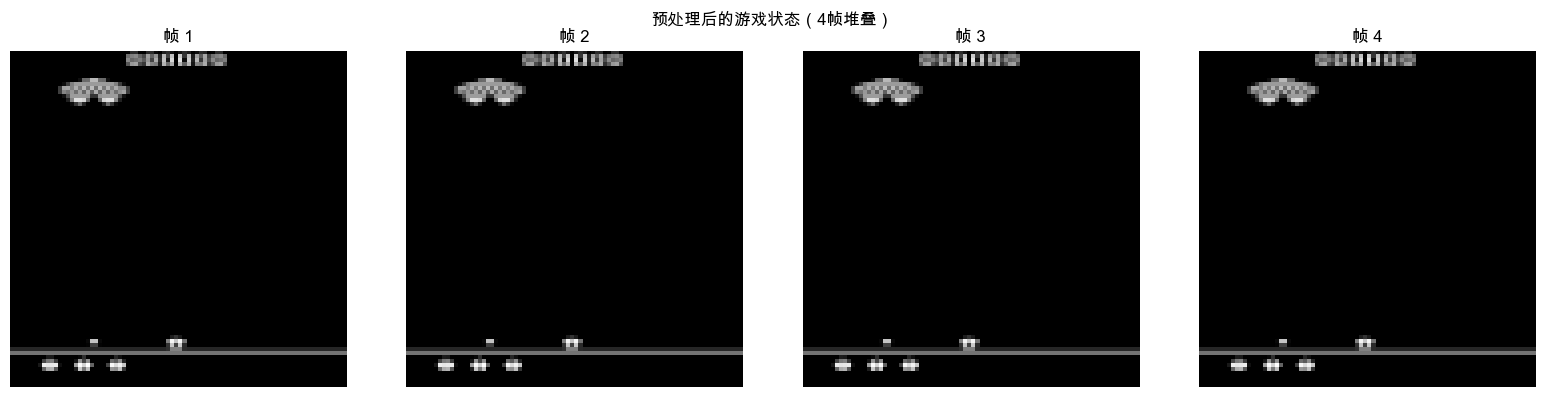

In [11]:
# 显示预处理后的状态
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].set_title(f'帧 {i+1}')
    axes[i].axis('off')

plt.suptitle('预处理后的游戏状态（4帧堆叠）')
plt.tight_layout()
plt.show()

## 模型架构

创建并查看 DQN 模型的架构。

In [19]:
# 设置设备
device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
print(f'使用设备: {device}')

# 创建模型
input_shape = env.observation_space.shape
n_actions = env.action_space.n

# 创建标准DQN模型
dqn_model = DQN(input_shape, n_actions)
print("标准DQN模型:")
print(dqn_model)

# 创建Dueling DQN模型
dueling_model = DuelingDQN(input_shape, n_actions)
print("\nDueling DQN模型:")
print(dueling_model)

# 计算模型参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n标准DQN参数数量: {count_parameters(dqn_model):,}")
print(f"Dueling DQN参数数量: {count_parameters(dueling_model):,}")

使用设备: mps
标准DQN模型:
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=7, bias=True)
  )
)

Dueling DQN模型:
DuelingDQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (advantage_stream): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU

## 训练过程

演示如何训练 Dueling DQN 智能体（简化版本，用于演示）。

In [ ]:
# 创建智能体（使用Dueling DQN）
model = DuelingDQN(input_shape, n_actions)
target_model = DuelingDQN(input_shape, n_actions)

agent = DQNAgent(
    model=model,
    target_model=target_model,
    env=env,
    device=device,
    buffer_size=10000,  # 较小的缓冲区用于演示
    batch_size=32,
    gamma=0.99,
    lr=1e-4,
    epsilon_start=1.0,
    epsilon_final=0.1,
    epsilon_decay=1000,
    target_update=100
)

print("Dueling DQN智能体创建完成！")

Dueling DQN智能体创建完成！


In [14]:
# 简化的训练循环（仅用于演示）
def train_demo(agent, env, n_episodes=50):
    rewards = []
    losses = []
    
    for episode in tqdm(range(n_episodes), desc="训练中"):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0
        
        done = False
        truncated = False
        
        while not (done or truncated) and steps < 1000:  # 限制步数
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            
            loss = agent.update_model()
            if loss is not None:
                episode_loss += loss
            
            if agent.steps_done % agent.target_update == 0:
                agent.update_target_model()
            
            state = next_state
            episode_reward += reward
            steps += 1
        
        rewards.append(episode_reward)
        losses.append(episode_loss / steps if steps > 0 else 0)
        
        if episode % 10 == 0:
            avg_reward = np.mean(rewards[-10:])
            print(f"Episode {episode}: Avg Reward = {avg_reward:.2f}")
    
    return rewards, losses

# 运行演示训练
print("开始演示训练...（这可能需要几分钟）")
rewards, losses = train_demo(agent, env, n_episodes=50)

开始演示训练...（这可能需要几分钟）


训练中:   0%|          | 0/50 [00:00<?, ?it/s]

Episode 0: Avg Reward = 231.00
Episode 10: Avg Reward = 199.50
Episode 20: Avg Reward = 310.80
Episode 30: Avg Reward = 287.70
Episode 40: Avg Reward = 266.70


## 结果可视化

可视化训练过程中的奖励和损失变化。

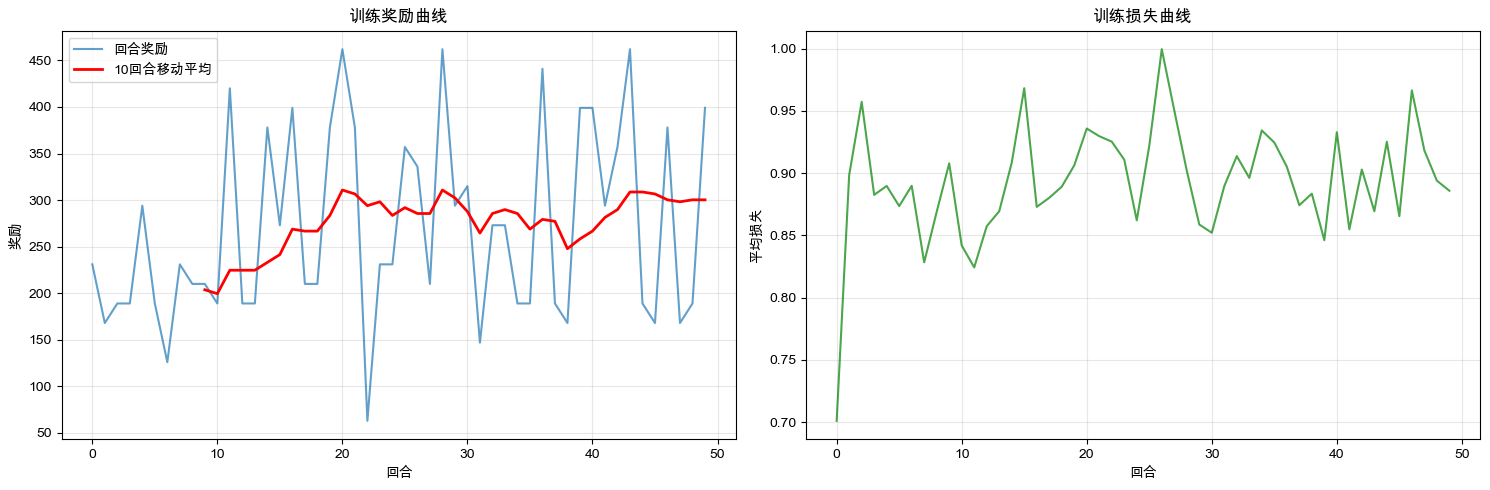

平均奖励: 269.64
最高奖励: 462.00
最低奖励: 63.00
奖励标准差: 101.53


In [15]:
# 绘制训练结果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 奖励曲线
ax1.plot(rewards, alpha=0.7, label='回合奖励')
# 计算移动平均
window_size = 10
if len(rewards) >= window_size:
    moving_avg = [np.mean(rewards[i:i+window_size]) for i in range(len(rewards)-window_size+1)]
    ax1.plot(range(window_size-1, len(rewards)), moving_avg, 'r-', linewidth=2, label=f'{window_size}回合移动平均')

ax1.set_xlabel('回合')
ax1.set_ylabel('奖励')
ax1.set_title('训练奖励曲线')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 损失曲线
ax2.plot(losses, 'g-', alpha=0.7)
ax2.set_xlabel('回合')
ax2.set_ylabel('平均损失')
ax2.set_title('训练损失曲线')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print(f"平均奖励: {np.mean(rewards):.2f}")
print(f"最高奖励: {np.max(rewards):.2f}")
print(f"最低奖励: {np.min(rewards):.2f}")
print(f"奖励标准差: {np.std(rewards):.2f}")

## 模型评估

评估训练后的智能体性能。

In [16]:
# 评估智能体
def evaluate_agent(agent, env, n_episodes=5):
    eval_rewards = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        steps = 0
        
        done = False
        truncated = False
        
        while not (done or truncated) and steps < 2000:
            action = agent.select_action(state, evaluate=True)  # 评估模式
            next_state, reward, done, truncated, _ = env.step(action)
            
            state = next_state
            episode_reward += reward
            steps += 1
        
        eval_rewards.append(episode_reward)
        print(f"评估回合 {episode+1}: 奖励 = {episode_reward:.2f}, 步数 = {steps}")
    
    return eval_rewards

# 运行评估
print("开始评估智能体...")
eval_rewards = evaluate_agent(agent, env, n_episodes=5)

print(f"\n评估结果:")
print(f"平均奖励: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"最高奖励: {np.max(eval_rewards):.2f}")
print(f"最低奖励: {np.min(eval_rewards):.2f}")

开始评估智能体...
评估回合 1: 奖励 = 0.00, 步数 = 41
评估回合 2: 奖励 = 0.00, 步数 = 105
评估回合 3: 奖励 = 0.00, 步数 = 97
评估回合 4: 奖励 = 0.00, 步数 = 50
评估回合 5: 奖励 = 0.00, 步数 = 130

评估结果:
平均奖励: 0.00 ± 0.00
最高奖励: 0.00
最低奖励: 0.00


## 总结

本演示展示了如何使用 Dueling DQN 算法训练智能体玩 Atari 游戏。主要步骤包括:

1. **环境预处理**: 将原始游戏画面转换为适合神经网络处理的格式
2. **模型设计**: 使用 Dueling DQN 架构，将Q值分解为状态价值函数和优势函数
3. **经验回放**: 存储和重用历史经验以提高学习效率
4. **目标网络**: 使用固定的目标网络稳定训练过程
5. **探索策略**: 使用ε-贪婪策略平衡探索和利用

Dueling DQN 的优势:
- 分离状态价值和动作优势的估计
- 在某些状态下能更好地学习状态价值
- 通常比标准DQN具有更好的性能

要获得更好的性能，建议:
- 增加训练回合数
- 使用更大的经验回放缓冲区
- 尝试其他改进算法（如 Double DQN、Rainbow DQN）
- 使用优先经验回放
- 调整超参数